# Lab 6: Stacking Regression Models

In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In this lab assignment, you will:

1. Load the Airbnb "listings" data set.
2. Use the stacking ensemble method to train four regressors.
3. Train and evaluate the same four individual regressors.
4. Compare the performance of the stacked ensemble model to that of the individual models.

**<font color='red'>Note: Some of the code cells in this notebook may take a while to run.</font>**

## Part 1: Load the Data Set

We will work with a preprocessed version of the Airbnb NYC "listings" data set. 

<b>Task</b>: In the code cell below, use the same method you have been using to load the data using `pd.read_csv()` and save it to DataFrame `df`.

You will be working with the file named "airbnb_readytofit.csv.gz" that is located in a folder named "data".

In [5]:
# YOUR CODE HERE
filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv.gz")
df = pd.read_csv(filename, header=0)

In [14]:
df.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,...,n_host_verifications,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,False,True,True,True,False,-0.578829,-2.845589,-0.054298,-0.054298,-1.007673,...,1.888373,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,False,True,True,True,False,-4.685756,-0.430024,-0.112284,-0.112284,0.067470,...,0.409419,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,False,True,True,True,False,0.578052,-2.473964,-0.112284,-0.112284,0.605041,...,-1.069535,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,False,True,False,True,False,0.578052,1.010024,-0.112284,-0.112284,-0.470102,...,-0.576550,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,False,True,True,True,False,-0.054002,-0.066308,-0.112284,-0.112284,-1.007673,...,0.902404,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Part 2: Create Training and Test Data Sets

So far, we mostly focused on classification problems. For this exercise, you will focus on a regression problem and predict a continuous outcome.

Your model will predict the price of a listing; the label is going to be 'price'.

### Create Labeled Examples 

<b>Task</b>: Create labeled examples from DataFrame `df`. 
In the code cell below carry out the following steps:

* Get the `price` column from DataFrame `df` and assign it to the variable `y`. This will be our label.
* Get all other columns from DataFrame `df` and assign them to the variable `X`. These will be our features. 

In [6]:
# YOUR CODE HERE
y = df['price']
X = df.drop(columns='price', axis=1)

In [7]:
y.head()

0   -0.030031
1   -0.562648
2    0.857665
3   -0.612359
4   -0.562648
Name: price, dtype: float64

In [8]:
X.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,...,n_host_verifications,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,False,True,True,True,False,-0.578829,-2.845589,-0.054298,-0.054298,-1.007673,...,1.888373,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,False,True,True,True,False,-4.685756,-0.430024,-0.112284,-0.112284,0.067470,...,0.409419,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,False,True,True,True,False,0.578052,-2.473964,-0.112284,-0.112284,0.605041,...,-1.069535,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,False,True,False,True,False,0.578052,1.010024,-0.112284,-0.112284,-0.470102,...,-0.576550,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,False,True,True,True,False,-0.054002,-0.066308,-0.112284,-0.112284,-1.007673,...,0.902404,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Split Labeled Examples Into Training and Test Sets

<b>Task</b>: In the code cell below, create training and test sets out of the labeled examples. 

1. Use scikit-learn's `train_test_split()` function to create the data sets.

2. Specify:
    * A test set that is 30 percent of the size of the data set.
    * A seed value of '1234'. 
    

In [9]:
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

## Part 3: Use the Stacking Ensemble Method to Train Four Regression Models and Evaluate the Performance

You will use the scikit-learn `StackingRegressor` class. For more information, consult the online [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html).

First let's import `StackingRegressor`:

In [10]:
from sklearn.ensemble import StackingRegressor

In this part of the assignment, we will try to use four models jointly. In the code cell below, we creates a list of tuples, each consisting of a scikit-learn model function and the corresponding shorthand name that we choose:

In [11]:
estimators = [("DT", DecisionTreeRegressor()),
              ("RF", RandomForestRegressor()),
              ("GBDT", GradientBoostingRegressor()),
              ("LR", LinearRegression())
             ]

<b>Task</b>: Call `StackingRegressor()` with the following parameters:

1. Assign the list `estimators` to the parameter `estimators`.
2. Specify a 5-fold cross-validation using the parameter `cv`.
3. Use the parameter 'passthrough=False'. 

Assign the results to the variable `stacking_model`.

As you read up on the definition of the `StackingRegressor` class, you will notice that by default, the results of each model are combined using a ridge regression (a "final regressor").

In [12]:
# YOUR CODE HERE 
stacking_model = StackingRegressor(estimators, cv=5, passthrough=False)

Let's train and evaluate this ensemble model using cross-validation:

<b>Task</b>: Use scikit-learn's `cross_val_score()` function on the `stacking_model` model to obtain the 3-fold cross-validation RMSE scores. In the code cell below, perform the following steps:

1. Call the function with the following arguments:

    1. your model object 
    2. your training data 
    3. specify the number of folds 
    4. specify the "scoring method": `scoring = 'neg_root_mean_squared_error'`

2. Compute the average RMSE score returned by the 3-fold cross-validation and save the result to `rmse_avg`(Recall that specifying `neg_root_mean_squared_error` will result in negative RMSE values, so you have to multiply each value by -1 to obtain the RMSE scores before obtaining the average RMSE).

<b>Note</b>: This may take a while to run.

In [13]:
print('Performing Cross-Validation...')

# YOUR CODE HERE
num_folds = 3
scores = -1*cross_val_score(stacking_model, X_train, y_train, cv=num_folds, scoring='neg_root_mean_squared_error')
rmse_avg = scores.mean()

print('End')
print('average score: {}'.format(rmse_avg))


Performing Cross-Validation...
End
average score: 0.6590978623239107


<b>Analysis</b>: 
1. Does the stacking model perform well? <br>
2. Which hyperparameters were used for each one of the models in the stack?<br>

Record your findings in the cell below.

The stacking model can improve the existing accuracy compared to individual models. The average score was shown that the training data may perform well.<br>
<b>Each model in the stack</b>:<br>
Linear Regression: no hyperparameters.<br>
Decision Tree: max_depth=8, min_samples_leaf=50<br>
Gradient Boosted Decision Tree: max_depth=2, n_estimators=300<br>
Random Forest Regressor: max_depth=32, n_estimators=300<br>

## Part 4: Improve the Performance of the Ensemble Model

Assume that you decided to further improve your model by tuning a few of the hyperparameters and finding the best ones. Do not run the code cell below, but simply analyze the code:

In [ ]:
"""
params = {
    "DT__max_depth": [2, 4, 8],
    "GBDT__n_estimators":[100,300]
    
}

stack_grid = GridSearchCV(stacking, params, cv=3, verbose=4, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1)
stack_grid.fit(X_train, y_train)
print(stack_grid.best_params_)
rf_grid.cv_results_['mean_test_score']


print("best parameters:", rf_grid.best_params_)

rmse_stack_cv = -1*rf_grid.best_score_
print("[STACK] RMSE for the best model is : {:.2f}".format(rmse_stack_cv))

"""

Running the code above is computationally costly (you are welcome to do so on your own time as an ungraded activity). For this lab, we will simply give away the resulting values of the best hyperparameters:<br>
```{'DT__max_depth': 8, 'GBDT__n_estimators': 100}```

<b>Task</b>: Create a new version of the 'estimators' list. You will use the same four regressors, but this time, you will pass the `max_depth` value above to the decision tree model, and the `n_estimators` value above to the gradient boosted decision tree. Save the estimators list to the variable `estimators_best`.

In [15]:
# YOUR CODE HERE
max_depth=8
n_estimators=100
estimators_best = [("DT", DecisionTreeRegressor()),
              ("RF", RandomForestRegressor(max_depth=max_depth)),
              ("GBDT", GradientBoostingRegressor(n_estimators=n_estimators)),
              ("LR", LinearRegression())
             ]

<b>Task</b>: Create a new `StackingRegressor` object with `estimators_best`. Name the model object `stacking_best_model`. Fit `stacking_best_model` to the training data.


In [18]:
print('Implement Stacking...')

# YOUR CODE HERE
stacking_best_model = StackingRegressor(estimators_best, cv=5, passthrough=False)
stacking_best_model.fit(X_train, y_train)
print('End')

Implement Stacking...
End


<b>Task:</b> Use the `predict()` method to test your ensemble model `stacking_best_model` on the test set (`X_test`). Save the result to the variable `stacking_best_pred`. Evaluate the results by computing the RMSE and R2 score. Save the results to the variables `rmse` and `r2`.

Complete the code in the cell below to accomplish this.

In [3]:
mean_squared_error?

In [19]:
# 1. Use predict() to test use the fitted model to make predictions on the test data
# YOUR CODE HERE
stacking_best_pred = stacking_best_model.predict(X_test)

# 2. Compute the RMSE using mean_squared_error()
# YOUR CODE HERE
rmse = mean_squared_error(y_test, stacking_best_pred, squared=False)

# 3. Compute the R2 score using r2_score()
# YOUR CODE HERE
r2 = r2_score(y_test, stacking_best_pred)

           
print('Root Mean Squared Error: {0}'.format(rmse))
print('R2: {0}'.format(r2))                       

Root Mean Squared Error: 0.6358838006003581
R2: 0.617012262776224


## Part 5: Fit and Evaluate Individual Regression Models

### a. Fit and Evaluate a Linear Regression

<b>Task:</b> Complete the code below to fit and evaluate a linear regression model:

In [20]:
# 1. Create the LinearRegression model object below and assign to variable 'lr_model'
# YOUR CODE HERE
lr_model = LinearRegression()

# 2. Fit the model to the training data below
# YOUR CODE HERE
lr_model.fit(X_train, y_train)

# 3.  Call predict() to use the fitted model to make predictions on the test data. Save the results to variable
# 'y_lr_pred'
# YOUR CODE HERE
y_lr_pred = lr_model.predict(X_test)

# 4: Compute the RMSE and R2 (on y_test and y_lr_pred) and save the results to lr_rmse and lr_r2
# YOUR CODE HERE
lr_rmse = mean_squared_error(y_test, y_lr_pred, squared=False)
lr_r2 = r2_score(y_test, y_lr_pred)


print('[LR] Root Mean Squared Error: {0}'.format(lr_rmse))
print('[LR] R2: {0}'.format(lr_r2))

[LR] Root Mean Squared Error: 0.7449320705359715
[LR] R2: 0.4743911252247154


### b. Fit and Evaluate a Decision Tree 

Let's assume you already performed a grid search to find the best model hyperparameters for your decision tree. (We are omitting this step to save computation time.) The best values are: `max_depth=8`, and `min_samples_leaf = 50`. You will train a decision tree with these hyperparameter values.

<b>Task:</b> Complete the code in the cell below:

In [21]:
# 1. Create the DecisionTreeRegressor model object using the hyperparameter values above and assign to 
# variable 'dt_model'
# YOUR CODE HERE
dt_model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=50)

# 2. Fit the model to the training data below
# YOUR CODE HERE
dt_model.fit(X_train, y_train)

# 3.  Call predict() to use the fitted model to make predictions on the test data. Save the results to variable
# 'y_dt_pred'
# YOUR CODE HERE
y_dt_pred = dt_model.predict(X_test)

# 4: Compute the RMSE and R2 (on y_test and y_dt_pred) and save the results to dt_rmse and dt_r2
# YOUR CODE HERE
dt_rmse = mean_squared_error(y_test, y_dt_pred, squared=False)
dt_r2 = r2_score(y_test, y_dt_pred)


print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))


[DT] Root Mean Squared Error: 0.7354145220750559
[DT] R2: 0.4877361028893348


### c. Fit and Evaluate a Gradient Boosted Decision Tree 

Let's assume you already performed a grid search to find the best model hyperparameters for your gradient boosted decision tree. (We are omitting this step to save computation time.) The best values are: `max_depth=2`, and `n_estimators = 300`. You will train a GBDT with these hyperparameter values.

<b>Task</b>: Complete the code in the cell below.

In [22]:
print('Begin GBDT Implementation...')

# 1. Create the  GradientBoostingRegressor model object below and assign to variable 'gbdt_model'
# YOUR CODE HERE
gbdt_model = GradientBoostingRegressor(max_depth=2, n_estimators=300)

# 2. Fit the model to the training data below
# YOUR CODE HERE
gbdt_model.fit(X_train, y_train)

# 3. Call predict() to use the fitted model to make predictions on the test data. Save the results to variable
# 'y_gbdt_pred'
# YOUR CODE HERE
y_gbdt_pred = gbdt_model.predict(X_test)

# 4. Compute the RMSE and R2 (on y_test and y_gbdt_pred) and save the results to gbdt_rmse and gbdt_r2
# YOUR CODE HERE
gbdt_rmse = mean_squared_error(y_test, y_gbdt_pred, squared=False)
gbdt_r2 = r2_score(y_test, y_gbdt_pred)


print('End')

print('[GBDT] Root Mean Squared Error: {0}'.format(gbdt_rmse))
print('[GBDT] R2: {0}'.format(gbdt_r2))                 




Begin GBDT Implementation...
End
[GBDT] Root Mean Squared Error: 0.6607904076233395
[GBDT] R2: 0.5864225931147928


### d. Fit and Evaluate  a Random Forest

Let's assume you already performed a grid search to find the best model hyperparameters for your random forest model. (We are omitting this step to save computation time.) The best values are: `max_depth=32`, and `n_estimators = 300`. 
You will train a random forest with these hyperparameter values.

<b>Task</b>: Complete the code in the cell below.

In [23]:
print('Begin RF Implementation...')

# 1. Create the  RandomForestRegressor model object below and assign to variable 'rf_model'
# YOUR CODE HERE
rf_model = RandomForestRegressor(max_depth=32, n_estimators=300)

# 2. Fit the model to the training data below
# YOUR CODE HERE
rf_model.fit(X_train, y_train)

# 3. Call predict() to use the fitted model to make predictions on the test data. Save the results to variable
# 'y_rf_pred'
# YOUR CODE HERE
y_rf_pred = rf_model.predict(X_test)

# 4. Compute the RMSE and R2 (on y_test and y_rf_pred) and save the results to rf_rmse and rf_r2
# YOUR CODE HERE
rf_rmse = mean_squared_error(y_test, y_rf_pred, squared=False)
rf_r2 = r2_score(y_test, y_rf_pred)

print('End')

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))


Begin RF Implementation...
End
[RF] Root Mean Squared Error: 0.6283545611532164
[RF] R2: 0.626028169693714


## Part 6: Visualize Model Performance

The code cell below will plot the RMSE and R2 score for the stacked ensemble model and each regressor. 

<b>Task:</b> Complete the code in the cell below.

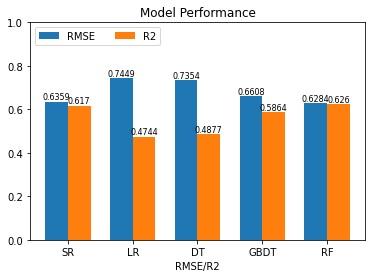

In [24]:
RMSE_Results = [rmse, lr_rmse, dt_rmse, gbdt_rmse, rf_rmse]
R2_Results = [r2, lr_r2, dt_r2, gbdt_r2, rf_r2]

rg= np.arange(5)
width = 0.35

# 1. Create bar plot with RMSE results
# YOUR CODE HERE
plt.bar(rg, RMSE_Results, width, label='RMSE')

# Add numbers on top of the bars for RMSE
for i, v in enumerate(RMSE_Results):
    plt.text(i, v, str(round(v, 4)), ha='center', va='bottom', fontsize=8)

# 2. Create bar plot with R2 results
# YOUR CODE HERE
plt.bar(rg+width, R2_Results, width, label='R2')

# Add numbers on top of the bars for R2
for i, v in enumerate(R2_Results):
    plt.text(i + width, v, str(round(v, 4)), ha='center', va='bottom', fontsize=8)

# 3. Call plt.xticks() to add labels under the bars indicating which model the pair of RMSE 
# and R2 bars correspond to
# YOUR CODE HERE
labels = ['SR', 'LR', 'DT', 'GBDT', 'RF']
plt.xticks(rg+width/2, labels)

# 4. Label the x and y axis of the plot: the x axis should be labeled "Models" and the y axis
# should be labeled "RMSE and R2"
# YOUR CODE HERE
plt.xlabel('Models')
plt.xlabel('RMSE/R2')

plt.ylim([0,1])
plt.title('Model Performance')
plt.legend(loc='upper left', ncol=2)
plt.show()


<b>Analysis</b>: Compare the performance of the stacking model with the individual models. Is the stacking model performing better?
Now that you are familiar with the Airbnb data, think about how a regression for price could be improved. What would you change, either at the feature engineering stage, or in the model selection, or at the stage of hyperparameter tuning?
Record your findings in the cell below.

The stacking model seems to be one of the best model in term of performance because of its RMSE value is high, which means the model's predictions are closer to the actual values. Even its R2 score is lower than the R2 score of RF model with a little amount, it still show the goodness of fit of a model. Besides, the RF model is kind of better than Stacking Model due to its lowest RMSE value and higher R2 score than stacking. Overall, the stacking model still do well compared to other models rather than RF. 
To improve the regression for price, we can analyzie more relevant features such as scaling or creating new features that helps improve model performance. Moreover, we can aslo optimize hyperparameters for individual models and stacking models using GridSearchCV to find the best results in improved performance. 